### Load the needed modules

In [1]:
import pandas as pd
import numpy as np
import copy
import warnings

# To filter out all warnings (not recommended)
warnings.filterwarnings("ignore")

# Machine Learning Tasks
from sklearn.metrics import roc_curve, auc, make_scorer, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb, xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import time

# Confidence Interval
import scipy.stats
from scipy import stats

# Explainable AI
import shap

# Diet-Met Correlation and Heatmaps
import pingouin as pg
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
import matplotlib as mpl
import seaborn as sns

### Load saved variables

In [2]:
store -r

### Functions

In [3]:
# this code chunk was copied and pasted. It is used to calculate the confidence intervals for the AUC-ROC score

"""
Created on Tue Nov  6 10:06:52 2018

@author: yandexdataschool

Original Code found in:
https://github.com/yandexdataschool/roc_comparison

updated: Raul Sanchez-Vazquez
"""

import numpy as np
import scipy.stats
from scipy import stats

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def compute_midrank_weight(x, sample_weight):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    cumulative_weight = np.cumsum(sample_weight[J])
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = cumulative_weight[i:j].mean()
        i = j
    T2 = np.empty(N, dtype=np.float)
    T2[J] = T
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count, sample_weight):
    if sample_weight is None:
        return fastDeLong_no_weights(predictions_sorted_transposed, label_1_count)
    else:
        return fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight)


def fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank_weight(positive_examples[r, :], sample_weight[:m])
        ty[r, :] = compute_midrank_weight(negative_examples[r, :], sample_weight[m:])
        tz[r, :] = compute_midrank_weight(predictions_sorted_transposed[r, :], sample_weight)
    total_positive_weights = sample_weight[:m].sum()
    total_negative_weights = sample_weight[m:].sum()
    pair_weights = np.dot(sample_weight[:m, np.newaxis], sample_weight[np.newaxis, m:])
    total_pair_weights = pair_weights.sum()
    aucs = (sample_weight[:m]*(tz[:, :m] - tx)).sum(axis=1) / total_pair_weights
    v01 = (tz[:, :m] - tx[:, :]) / total_negative_weights
    v10 = 1. - (tz[:, m:] - ty[:, :]) / total_positive_weights
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def fastDeLong_no_weights(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating
              Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth, sample_weight):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    if sample_weight is None:
        ordered_sample_weight = None
    else:
        ordered_sample_weight = sample_weight[order]

    return order, label_1_count, ordered_sample_weight


def delong_roc_variance(ground_truth, predictions, sample_weight=None):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(
        ground_truth, sample_weight)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov

In [4]:
# Code by PedroUria to consider stdev when choosing best model in GridSearchCV
# full code here: https://colab.research.google.com/drive/1UdhvUJLGnTvMwAoRQ85QUlPt2qgM7guy#scrollTo=WEoHhtSekoYI
# github page where the user links to the colab: https://github.com/scikit-learn/scikit-learn/issues/12865

def find_best_index_(cv_results_):
    """ 
    Returns the index of the best model, based on the mean but also on the standard deviation.
    This will choose the model with the highest mean unless its standard deviation is 5 higher than the second best model based on mean,
    which needs to be less than 0.95 * best_mean.
    """

    # Hardcoding these values to showcase functionality!
#     cv_results_["mean_test_score"] = np.array([0.7033, 0.7, 0.6, 0.5])
#     cv_results_["std_test_score"] = np.array([0.1674, 0.0082, 0.1, 0.05])

    best_mean_idx = np.argmax(cv_results_["mean_test_score"])
    second_best_mean_idx = np.argsort(cv_results_["mean_test_score"])[-2]
    if cv_results_["std_test_score"][best_mean_idx] > 5 * cv_results_["std_test_score"][second_best_mean_idx] and cv_results_["mean_test_score"][second_best_mean_idx] > 0.95 * cv_results_["mean_test_score"][best_mean_idx]:
        return second_best_mean_idx
    return best_mean_idx

### Read in the data

In [5]:
file_path = ["../R Processed Data/BB_imp_sc_trans_filt_label.csv", 
             "../R Processed Data/HMP_imp_sc_trans_filt_label.csv"]

file_name = ["UK Biobank (plasma)",
             "HMP2 IBDMDB (feces)"]

X_list = []
y_list = []
X_train_list = []
y_train_list = []
X_test_list = []
y_test_list = []


for dataset_id in range(len(file_path)):
    X = pd.read_csv(file_path[dataset_id], index_col=0).sort_index()
    y = X['Label']
    y = y.replace({'IBD': 1, 'nonIBD': 0})
    X = X.drop('Label', axis=1)
#     if dataset_id == 1:
#         X = X.drop('NUA', axis=1)
    
    ### TRAIN TEST SPLIT ###
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=True, stratify = y, random_state=42)
    
#     ## TRAIN TEST SPLIT ###
#     X_train, X_test, y_train, y_test = train_test_split(
#        X_train, y_train, test_size=0.2, shuffle=True, stratify = y_train, random_state=42)
    
    X_list.append(X)
    y_list.append(y)
    X_train_list.append(X_train)
    y_train_list.append(y_train)
    X_test_list.append(X_test)
    y_test_list.append(y_test)

In [6]:
file_name = ["UKBB (plasma)",
             "HMP2 (feces)"]

model_name = ["XGB",
              "LGBM",
              "RF",
              "LASSO"]

In [7]:
param_grids = {
    'xgb': {
        'n_estimators': list(range(100, 500, 100)),
        'max_depth': [5, 10, 20, 30],
        'learning_rate': [0.1, 0.01, 0.05],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    },
    'lgb': {
        'num_leaves': [31, 63, 127],
        'max_depth': [5, 10, 20, 30],
        'learning_rate': [0.1, 0.01, 0.05],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    },
    'rf': {
        'n_estimators': list(range(100, 500, 100)),
        'max_depth': [5, 10, 20, 30],
        'max_samples': [0.8, 1.0], 
        'max_features': ['sqrt', 0.3, 0.5, 1.0],
        'criterion': ['gini', 'entropy']
    },
    'lasso': {
        'C': list(np.logspace(-3,3,7))
    }
}

models = {
    'xgb': xgb.XGBClassifier(objective = 'binary:logistic', seed=42),
    'lgb': lgb.LGBMClassifier(objective='binary', seed=42),
    'rf': RandomForestClassifier(random_state=42),
    'lasso': LogisticRegression(penalty='l1', max_iter=10000, solver='liblinear', random_state=42)
}

classifier_data = {
    'xgb': {
        'grid_best_mscore': None,
        'grid_best_std': None,
        'classifier': None,
        'fpr': None,
        'tpr': None,
        'auc_score': None,
        'y_pred_prob': None
    },
    'lgb': {
        'grid_best_mscore': None,
        'grid_best_std': None,
        'classifier': None,
        'fpr': None,
        'tpr': None,
        'auc_score': None,
        'y_pred_prob': None
    },
    'rf': {
        'grid_best_mscore': None,
        'grid_best_std': None,
        'classifier': None,
        'fpr': None,
        'tpr': None,
        'auc_score': None,
        'y_pred_prob': None,
    },
    'lasso': {
        'grid_best_mscore': None,
        'grid_best_std': None,
        'classifier': None,
        'fpr': None,
        'tpr': None,
        'auc_score': None,
        'y_pred_prob': None
    }
}

dataset_classifier_data = {}

## Model Optimization

In [8]:
for dataset_id in range(len(file_path)):
    print(file_name[dataset_id])
    print("="*60)
    print()
    
    for i, classifier in enumerate(classifier_data): 
        print(model_name[i])    

        base_model = models[classifier] 
        param_grid = param_grids[classifier]

        scorer = make_scorer(roc_auc_score, needs_threshold=True)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # retrieve the train and test data for biobank
        X_train = X_train_list[dataset_id]
        y_train = y_train_list[dataset_id]
        X_test = X_test_list[dataset_id]
        y_test = y_test_list[dataset_id]

        time_start = time.time()

        #grid search done with refit, so to account considering st_dev when choosing best param
        grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, 
                                   scoring=scorer, refit=find_best_index_,
                                   cv=skf, n_jobs=-1)

        grid_search.fit(X_train.values, y_train)

        time_grid = time.time() - time_start

        best_grid_model = grid_search.best_estimator_
        best_grid_model_params = grid_search.best_params_
        best_idx = np.argsort(grid_search.cv_results_['mean_test_score'])[-1]
        best_grid_model_score = grid_search.cv_results_['mean_test_score'][best_idx]
        best_grid_model_std = grid_search.cv_results_['std_test_score'][best_idx]

        print(f"Grid Search took {time_grid/60:.2f} mins ({time_grid:.2f} secs)")
        print(f"Best parameters: {best_grid_model_params}")
        print(f"Grid Validation AUC score: {best_grid_model_score}")
        print(f"Grid Validation std: {best_grid_model_std}")

        classifier_data[classifier]['classifier'] = best_grid_model
        classifier_data[classifier]['grid_best_mscore']: best_grid_model_score
        classifier_data[classifier]['grid_best_std']: grid_search.cv_results_['std_test_score'][best_idx]

        # predict and evaluate model performance (AUC)
        y_pred_prob = best_grid_model.predict_proba(X_test.values)[:, 1]
        classifier_data[classifier]['y_pred_prob'] = y_pred_prob

        fpr_num, tpr_num, _ = roc_curve(y_test, y_pred_prob)
        classifier_data[classifier]['fpr'] = fpr_num
        classifier_data[classifier]['tpr'] = tpr_num
        auc_score_num = auc(fpr_num, tpr_num)
        classifier_data[classifier]['auc_score'] = auc_score_num

        # Calculate other performance metrics
        true_labels = y_test.values
        predicted_labels = best_grid_model.predict(X_test.values)
        confusion = confusion_matrix(true_labels, predicted_labels)
        TP = confusion[1, 1]
        TN = confusion[0, 0]
        FP = confusion[0, 1]
        FN = confusion[1, 0]
        specificity = TN / (TN + FP)
        recall = recall_score(true_labels, predicted_labels)
        precision = precision_score(true_labels, predicted_labels)
        f1 = f1_score(true_labels, predicted_labels)
        balanced_accuracy = balanced_accuracy_score(true_labels, predicted_labels)

        # calculate the AUC CI
        alpha = .95
        aucc, auc_cov = delong_roc_variance(
            y_test,
            y_pred_prob)
        auc_std = np.sqrt(auc_cov)
        lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)
        ci = stats.norm.ppf(
            lower_upper_q,
            loc=aucc,
            scale=auc_std)
        ci[ci > 1] = 1

        # print results
        print("Test AUC score: ", auc_score_num)
        print(f"{alpha*100} % AUC CI: {ci}")
        print("Specificity:", specificity)
        print("Sensitivity (Recall):", recall)
        print("Precision:", precision)
        print("F1 Score:", f1)
        print("Balanced Accuracy:", balanced_accuracy)
        print("-"*40)
        
    dataset_classifier_data[file_name[dataset_id]] = copy.deepcopy(classifier_data)
    print()

UKBB (plasma)

XGB
Grid Search took 21.33 mins (1279.93 secs)
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Grid Validation AUC score: 0.6460265566975825
Grid Validation std: 0.022477284295198928
Test AUC score:  0.674746719249337
95.0 % AUC CI: [0.62455681 0.72493663]
Specificity: 0.9685863874345549
Sensitivity (Recall): 0.17532467532467533
Precision: 0.6923076923076923
F1 Score: 0.27979274611398963
Balanced Accuracy: 0.5719555313796152
----------------------------------------
LGBM
Grid Search took 1.34 mins (80.13 secs)
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 31, 'subsample': 0.8}
Grid Validation AUC score: 0.639756515694376
Grid Validation std: 0.02577270501952031
Test AUC score:  0.6758686339838172
95.0 % AUC CI: [0.62530314 0.72643412]
Specificity: 0.9633507853403142
Sensitivity (Recall): 0.22727272727272727
Precision: 0.7142857142857143
F1 Score: 0.34

In [9]:
%store dataset_classifier_data

Stored 'dataset_classifier_data' (dict)


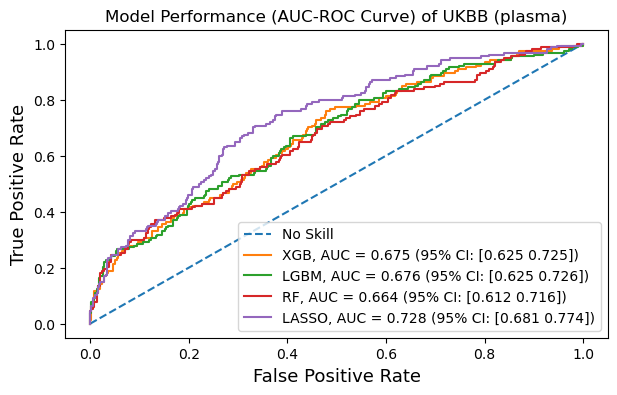

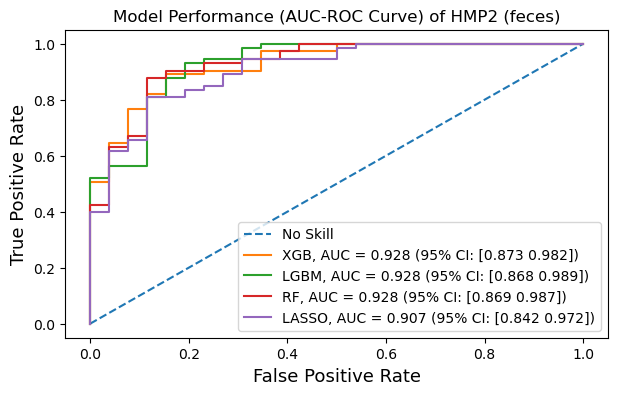

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

# generate for No SKill
ns_probs = [0 for _ in range(len(y_test_list[1]))]
ns_auc = roc_auc_score(y_test_list[1], ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test_list[1], ns_probs)

for i, dataset in enumerate(file_name):
    plt.figure(figsize=(7, 4))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    y_test = y_test_list[i]
    for j, classifier in enumerate(dataset_classifier_data[dataset]):
        cf_data = dataset_classifier_data[dataset][classifier]
        y_pred_prob = cf_data['y_pred_prob']
        # calculate the AUC CI
        alpha = .95
        aucc, auc_cov = delong_roc_variance(
            y_test,
            y_pred_prob)
        auc_std = np.sqrt(auc_cov)
        lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)
        ci = stats.norm.ppf(
            lower_upper_q,
            loc=aucc,
            scale=auc_std)
        ci[ci > 1] = 1
        plt.plot(cf_data['fpr'], cf_data['tpr'], label='{}, AUC = {:.3f} (95% CI: {})'.format(model_name[j], cf_data['auc_score'], np.round(ci,3)))
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.title(f'Model Performance (AUC-ROC Curve) of {file_name[i]}', size=12)
    plt.legend()
    plt.savefig(f'ML and XAI/AUC-ROC Curve of {file_name[i]}.png')
    plt.show()

## Choosing the best classifier for each dataset

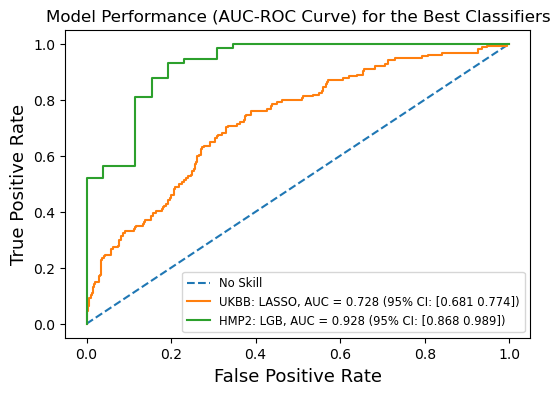

In [11]:
plt.figure(figsize=(6, 4))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')

dataset_short = ['UKBB', 'HMP2']

for i, dataset in enumerate(file_name):
    classifiers = ['xgb', 'lgb', 'rf', 'lasso']
    best_classifier = None
    best_score = float('-inf')
    y_test = y_test_list[i]
    # Find the classifier with the highest auc_score or choose xgb if both scores are equal
    for classifier in classifiers:
        score = dataset_classifier_data[dataset][classifier]['auc_score']
        if score > best_score:
            best_score = score
            best_classifier = classifier   
        elif score == best_score:
            # Priority: lgb (performed better in other parameters in hmp2) > rf > xgb > lasso
            if classifier == 'lgb':
                best_classifier = classifier
            elif classifier == 'rf' and best_classifier != 'lgb':
                best_classifier = classifier
            elif classifier == 'xgb' and best_classifier not in ['rf', 'lgb']:
                best_classifier = classifier
            elif classifier == 'lasso' and best_classifier not in ['rf', 'lgb', 'xgb']:
                best_classifier = classifier
    cf_data = dataset_classifier_data[dataset][best_classifier]
    y_pred_prob = cf_data['y_pred_prob']
    # calculate the AUC CI
    alpha = .95
    aucc, auc_cov = delong_roc_variance(
        y_test,
        y_pred_prob)
    auc_std = np.sqrt(auc_cov)
    lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)
    ci = stats.norm.ppf(
        lower_upper_q,
        loc=aucc,
        scale=auc_std)
    ci[ci > 1] = 1
    plt.plot(cf_data['fpr'], cf_data['tpr'], label='{}: {}, AUC = {:.3f} (95% CI: {})'.format(dataset_short[i], best_classifier.upper(), cf_data['auc_score'], np.round(ci,3)))
plt.xlabel('False Positive Rate', size=13)
plt.ylabel('True Positive Rate', size=13)
plt.title(f'Model Performance (AUC-ROC Curve) for the Best Classifiers', size=12)
plt.legend(fontsize='small')
plt.savefig(f'ML and XAI/AUC-ROC Curve for the Best Classifiers.png')
plt.show()

------------
## Explainable AI: SHAP

In [12]:
shap_dataset_classifier_data = {}
import shap
# Calculate SHAP values
for i, dataset in enumerate(file_name):
    classifiers = ['xgb', 'lgb', 'rf'] # didn't include LASSO because I wanted to use an ML heavy model in order to utilize SHAP's features well
    best_classifier = None
    best_score = float('-inf')
     
    # Find the classifier with the highest auc_score or choose xgb if both scores are equal
    for classifier in classifiers:
        score = dataset_classifier_data[dataset][classifier]['auc_score']
        if score > best_score:
            best_score = score
            best_classifier = classifier
        elif score == best_score:
            # Priority: lgb (performed better in other parameters) in hmp2> rf > xgb > lasso
            if classifier == 'lgb':
                best_classifier = classifier
            elif classifier == 'rf' and best_classifier != 'lgb':
                best_classifier = classifier
            elif classifier == 'xgb' and best_classifier not in ['rf', 'lgb']:
                best_classifier = classifier
            elif classifier == 'lasso' and best_classifier not in ['rf', 'lgb', 'xgb']:
                best_classifier = classifier

    print(dataset)
    print(best_classifier)
    print()
    
    cf_data = dataset_classifier_data[dataset][best_classifier]
    if best_classifier == 'rf':
        explainer = shap.Explainer(cf_data['classifier'])  
    elif best_classifier == 'lasso':
        masker = shap.maskers.Independent(data = X_test_list[i])
        explainer = shap.LinearExplainer(cf_data['classifier'], masker=masker)  
    elif best_classifier == 'lgb':
        explainer = shap.TreeExplainer(cf_data['classifier'])
        if isinstance(cf_data['classifier'], lgb.LGBMClassifier):
             explainer.model.original_model.params['objective'] = 'binary'
    else: 
        explainer = shap.TreeExplainer(cf_data['classifier'])
        
    # initialize it as an empty dictionary
    shap_dataset_classifier_data.setdefault(dataset, {})
    shap_dataset_classifier_data[dataset].setdefault(best_classifier, {})
    
    shap_dataset_classifier_data[dataset][best_classifier]['explainer'] = explainer
    dataset_classifier_data[dataset][best_classifier]['explainer'] = explainer
    
    # lasso doesn't create two matrices for the two classes, but one only
    if best_classifier == 'lasso':
        shap_values = explainer.shap_values(X_test_list[i])
    else:
        shap_values = explainer.shap_values(X_test_list[i])[1] # 1 for the positive class, IBD
    shap_dataset_classifier_data[dataset][best_classifier]['shap_values'] = shap_values
    dataset_classifier_data[dataset][best_classifier]['shap_values'] = shap_values
    
    shap_values_df = pd.DataFrame(shap_values, columns=X_test_list[i].columns, index=X_test_list[i].index)
    shap_dataset_classifier_data[dataset][best_classifier]['shap_values_df'] = shap_values_df
    dataset_classifier_data[dataset][best_classifier]['shap_values_df'] = shap_values_df

UKBB (plasma)
lgb

HMP2 (feces)
lgb



In [13]:
ukbb_features = [h for h in range(len(file_name))]

In [14]:
# Finding the top features

selected_features_list = []

for dataset in file_name:
    for classifier, shap_data in shap_dataset_classifier_data[dataset].items():
        if 'shap_values_df' in shap_data:
            print(classifier)
            shap_values_df = shap_dataset_classifier_data[dataset][classifier]['shap_values_df']
            shap_values_df_normalized = shap_values_df.div(shap_values_df.sum().sum())


    # Calculate the mean of absolute values for each column
    abs_mean_values = np.abs(shap_values_df).mean()

    # Initialize variables
    total_contribution = 0
    selected_features = []
    bottom_features = []

    # Sort the features by absolute mean values in descending order
    sorted_features = abs_mean_values.sort_values(ascending=False)

    # selecting the top 20 features
    selected_features = sorted_features[:20].index.values
    total_contribution = sorted_features[:20].values.sum()

    # Calculate the top-bottom ratio
    count = len(selected_features)
    bottom_features = abs_mean_values.nsmallest(count).index.tolist()
    bottom_features_contribution =  abs_mean_values[bottom_features].sum() / abs_mean_values.sum()
    top_features_contribution = total_contribution / abs_mean_values.sum()
    tb_ratio = top_features_contribution / bottom_features_contribution

    # Print the selected features, their cumulative contribution, and odds ratio
    print("Selected Features:", selected_features)
    print("Number of Features:", len(selected_features))
    print("% of Total Features:", count/len(abs_mean_values)*100)
    print("Cumulative Contribution of Top Features:", top_features_contribution)
    print("Cumulative Contribution of Bottom Features:", bottom_features_contribution)
    print("Ratio of Top to Bottom Features:", tb_ratio)
    print()
    
    selected_features_list.append(selected_features)
    if dataset == "UKBB (plasma)":
        ukbb_features[1] = selected_features

lgb
Selected Features: ['GlycA' 'S-LDL-FC' 'Albumin' 'Unsaturation' 'Glycine' 'Valine'
 'XXL-VLDL-TG' 'Acetate' 'Creatinine' 'Leucine' 'XL-HDL-FC'
 'Phenylalanine' 'Pyruvate' 'Glucose' 'Histidine' 'Omega-3' 'Citrate'
 'Acetone' 'Acetoacetate' 'Alanine']
Number of Features: 20
% of Total Features: 54.054054054054056
Cumulative Contribution of Top Features: 0.8271694959800644
Cumulative Contribution of Bottom Features: 0.2189802887834616
Ratio of Top to Bottom Features: 3.7773696462607647

lgb
Selected Features: ['NUA' 'Pyridoxine' 'C18:1 LPC-P' 'N-AcPut' 'C16:0 SM' 'C36:2 PC'
 'Urobilin' 'Acetyl-GalN' 'Metformin' 'Hydroxycotinine' 'N-MePro' 'NMPC'
 'Acetaminophen' '1-MNA' 'NAM' 'Histidinol' '7-MeG' 'Cadaverine' 'Quinine'
 'Pterin']
Number of Features: 20
% of Total Features: 12.422360248447205
Cumulative Contribution of Top Features: 0.5985680230836609
Cumulative Contribution of Bottom Features: 0.007381423504072829
Ratio of Top to Bottom Features: 81.09113679135068



#### Generating the Summary Plots

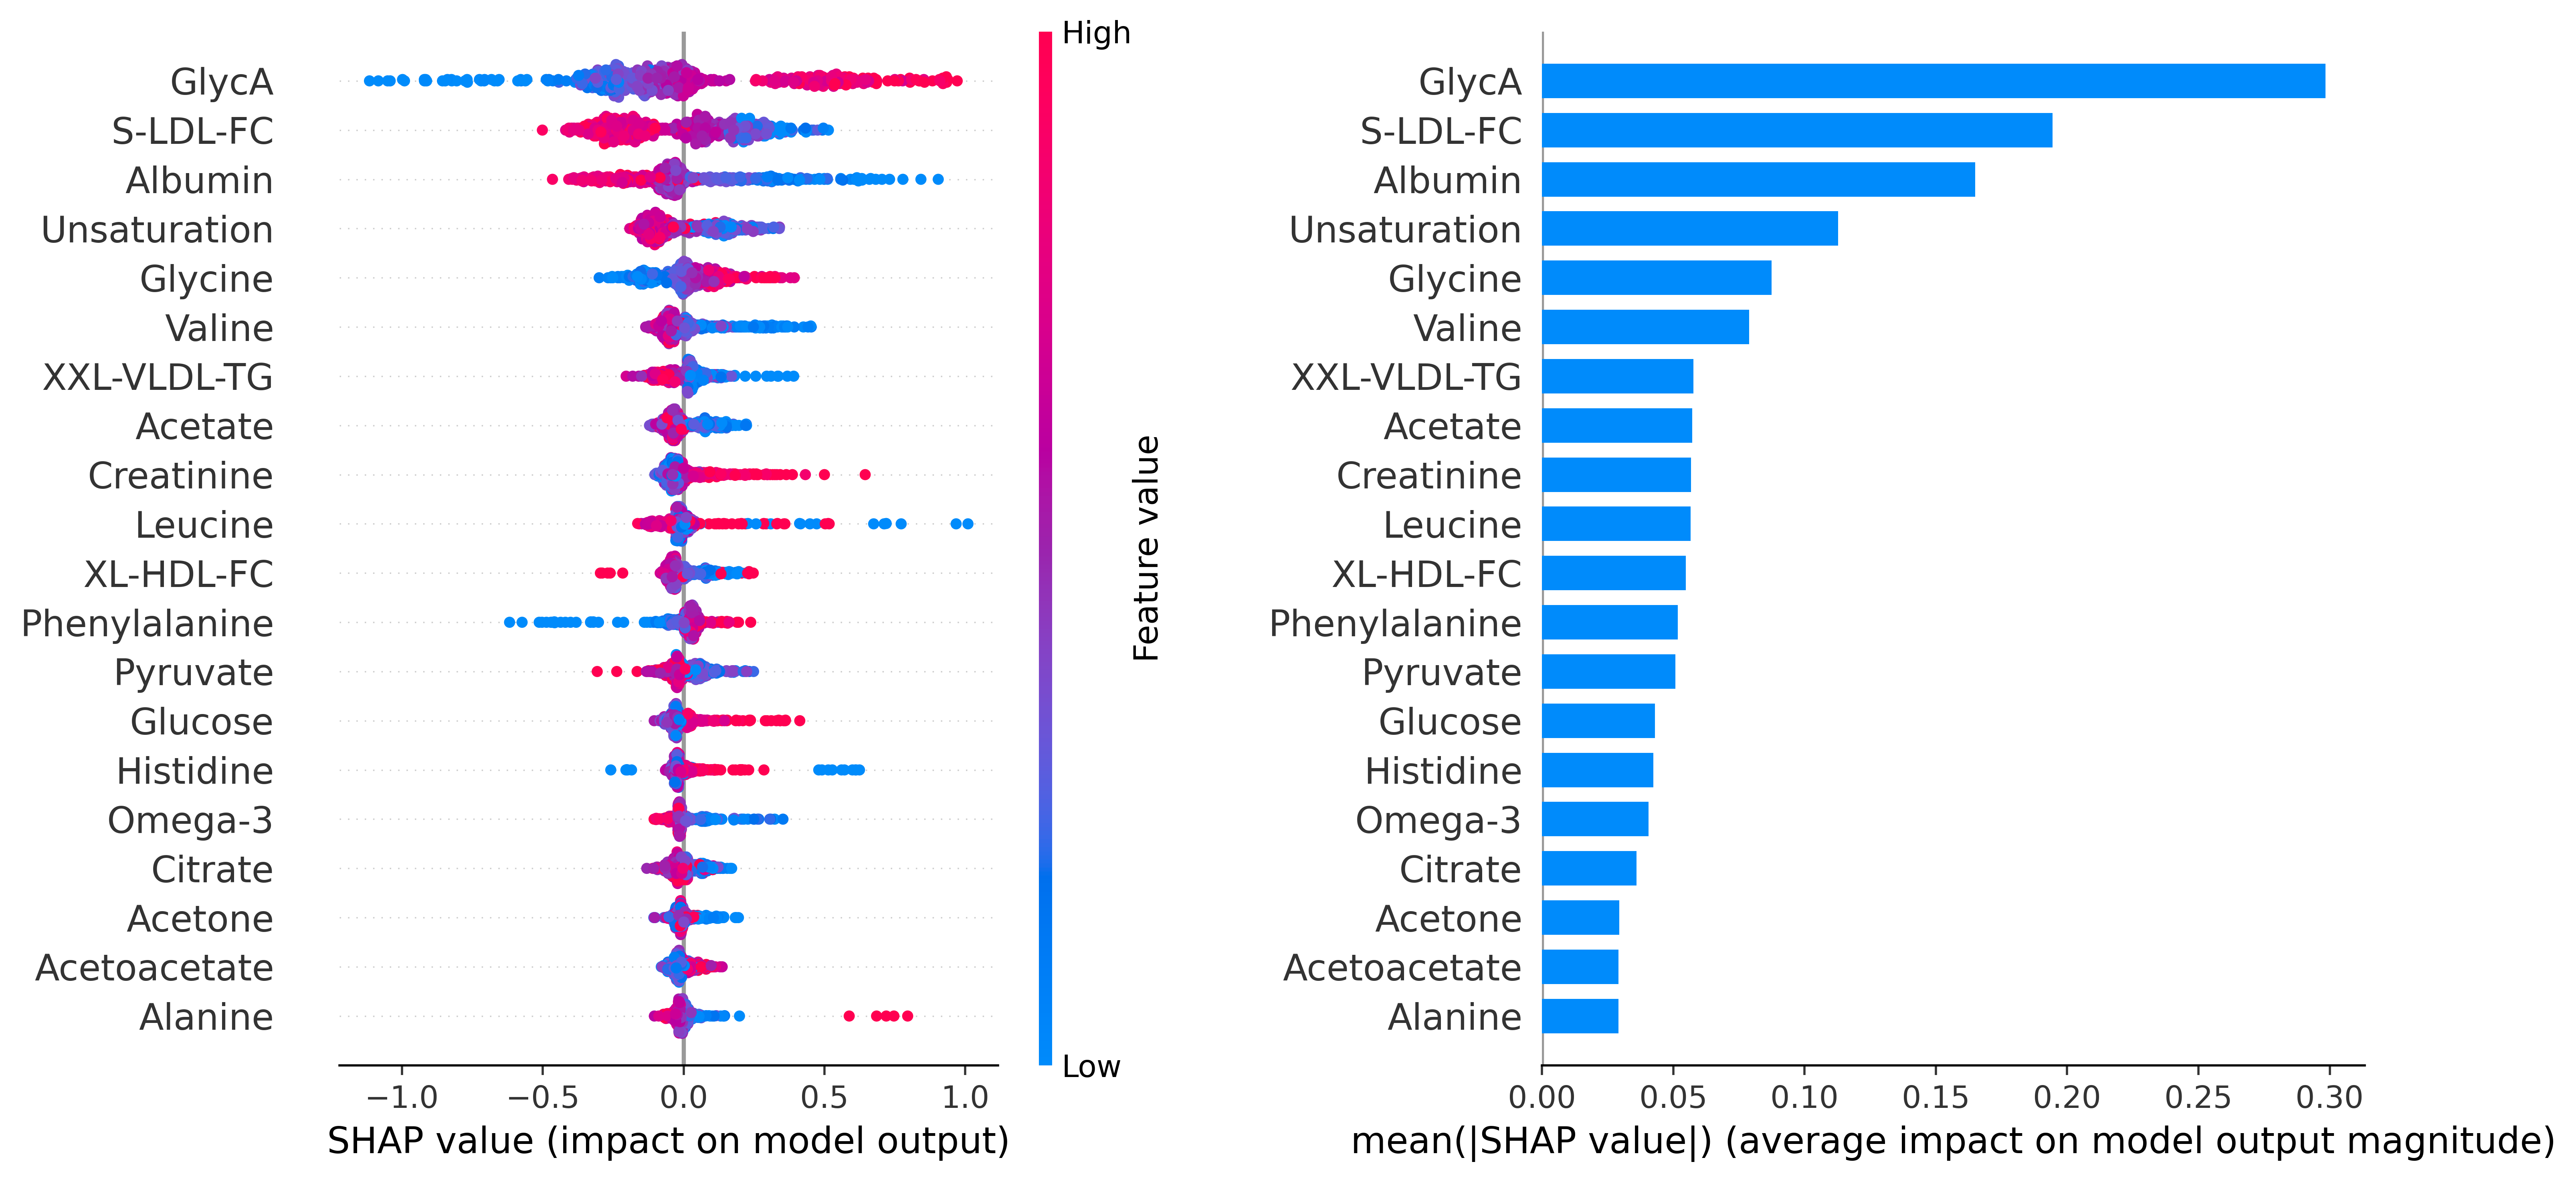

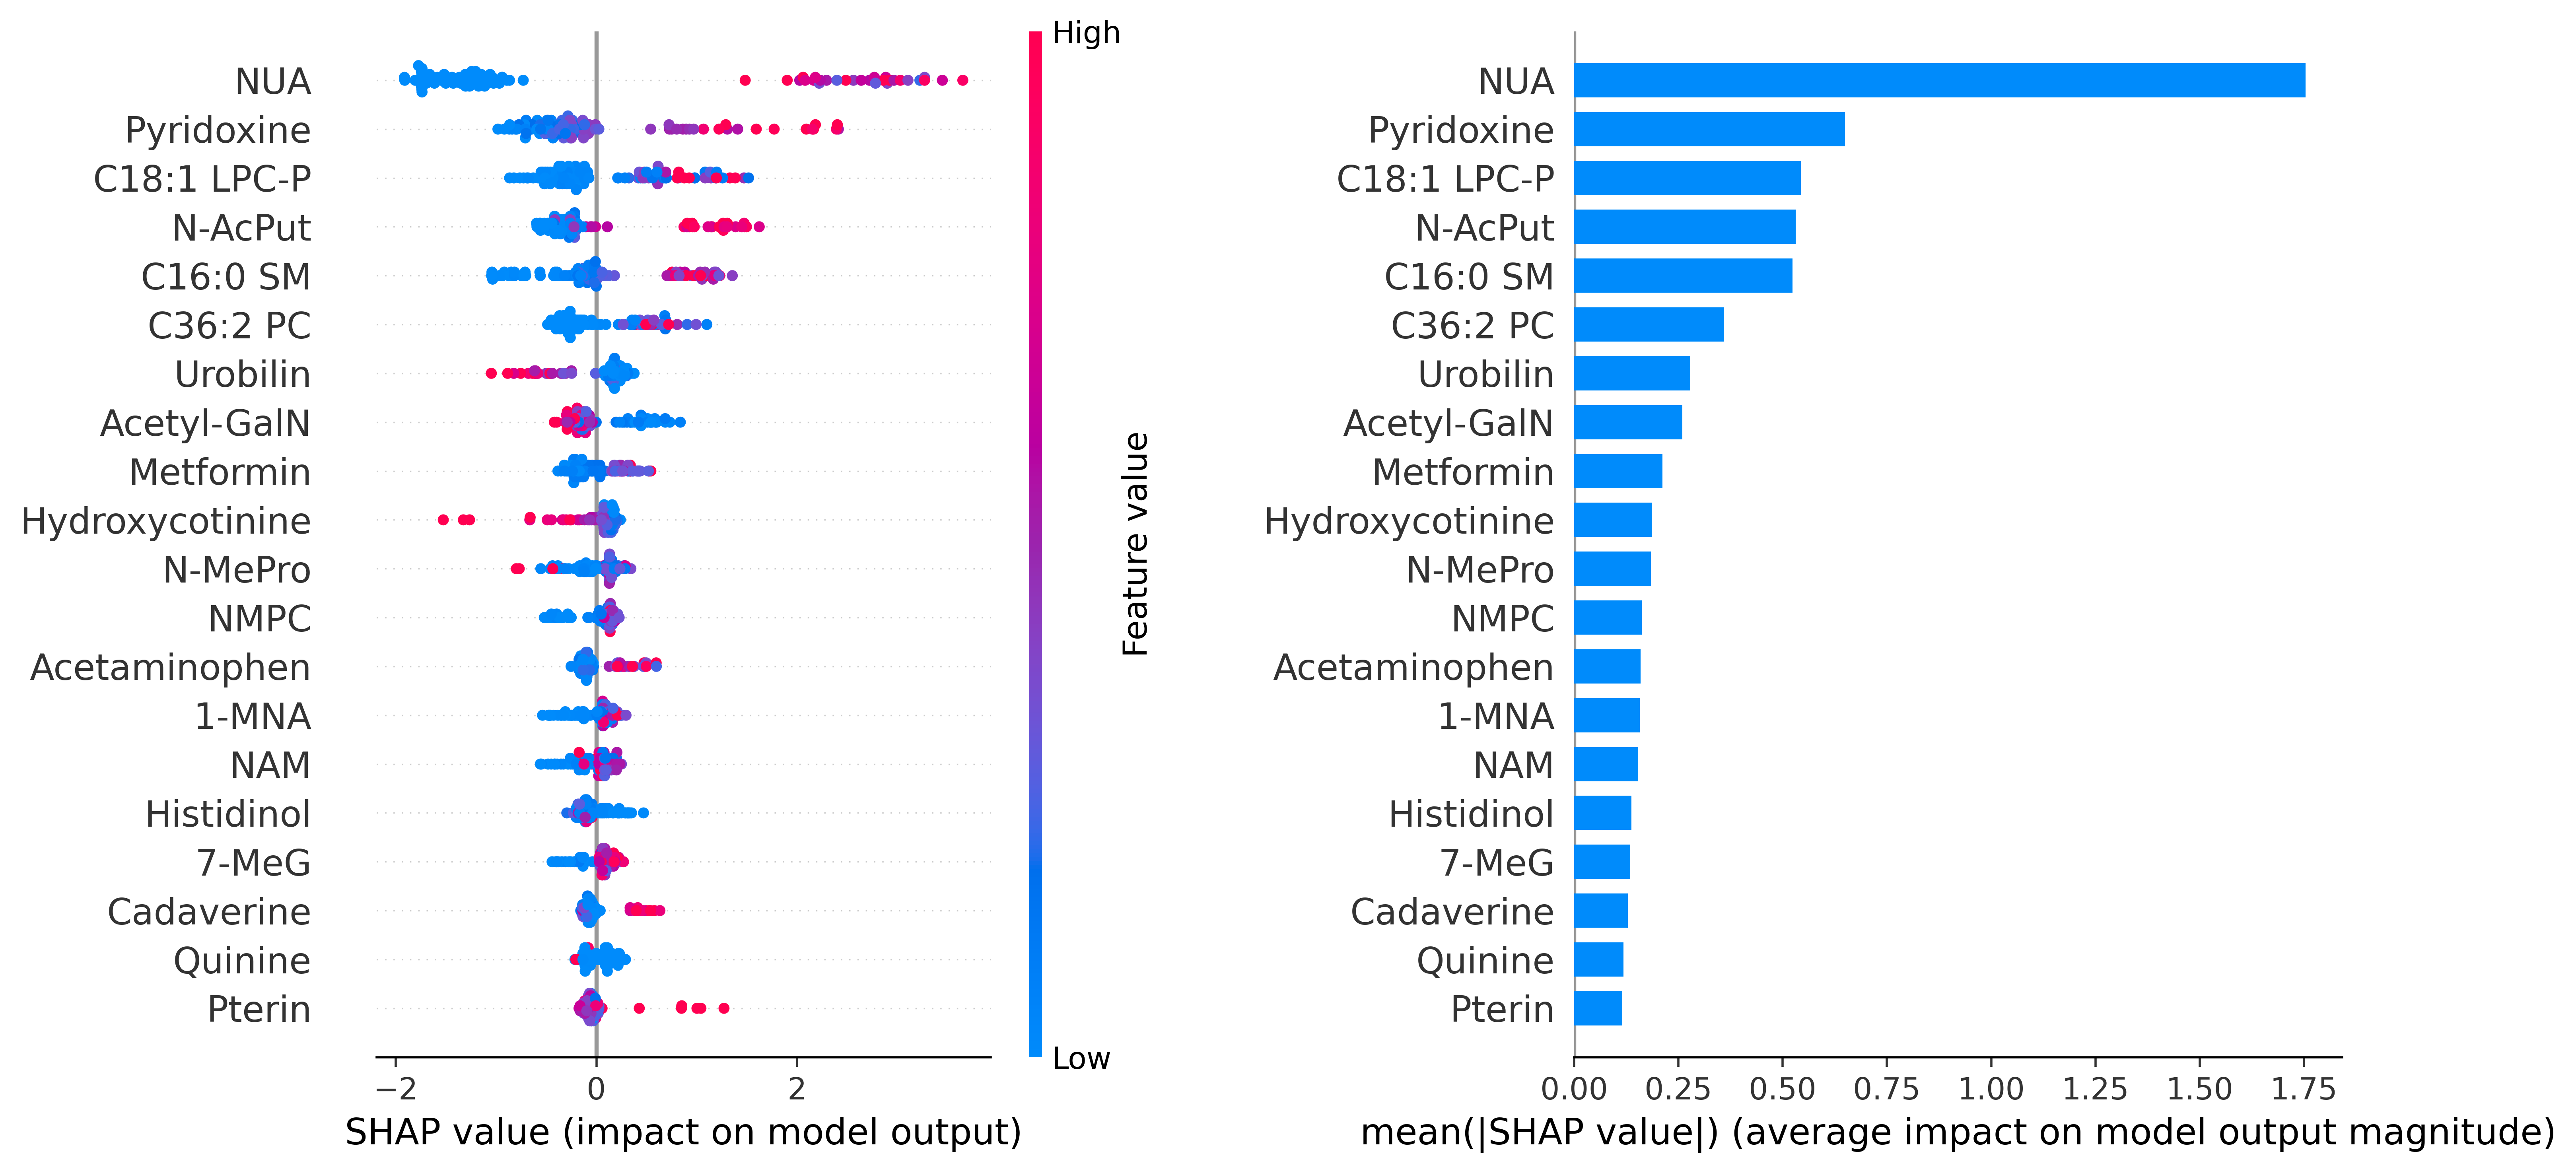

In [15]:
RankedMetaboliteData = [h for h in range(len(file_name))]

for i, dataset in enumerate(file_name):
    for classifier, shap_data in shap_dataset_classifier_data[dataset].items():
        if 'shap_values' in shap_data:
            shap_values = shap_dataset_classifier_data[dataset][classifier]['shap_values']
            shap_values_df = shap_dataset_classifier_data[dataset][classifier]['shap_values_df']
            shap_values_df_normalized = shap_values_df.div(shap_values_df.sum().sum())
            shap_values_normalized = shap_values / np.sum(shap_values)
    fig = plt.figure(dpi=500)
    ax0 = fig.add_subplot(131)
    shap.summary_plot(shap_values, X_test_list[i], show=False, max_display=len(selected_features_list[0]), plot_type='dot')
    ax1 = fig.add_subplot(132)
    shap.summary_plot(shap_values,  X_test_list[i], show=False, max_display=len(selected_features_list[0]), plot_type='bar')
    plt.gcf().set_size_inches(18,6)
    plt.tight_layout() 
    # export the figures
    plt.savefig('ML and XAI/{}_summary_mean.png'.format(dataset), bbox_inches='tight')
    plt.show()
    # Export the ranked metabolites:
    import numpy as np
    vals= np.abs(shap_values).mean(0)
    feature_importance = pd.DataFrame(list(zip(X_test_list[i].columns, vals)), columns=['col_name', 'feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
    ranked_features = feature_importance['col_name'].values
    # export the original dataframe with the values but shap ranked
    RankedMetaboliteData[i] = pd.concat([y_list[i], X_list[i][ranked_features]], axis = 1)
    RankedMetaboliteData[i].to_csv(f"ML and XAI/X values Shap-Ranked for {classifier}-{dataset}.csv", index = True)
    # export the shap values dataframe in the shap-ranked order
    pd.concat([y_test_list[i], shap_values_df[ranked_features]], axis = 1).to_csv(f"ML and XAI/SHAP values Shap-Ranked for {classifier}-{dataset}.csv", index = True)

##### Store the variables

In [16]:
%store shap_dataset_classifier_data

Stored 'shap_dataset_classifier_data' (dict)


# Diet - Metabolite Interactions

UKBB (plasma) IBD:
Total Correlations (|r| >= 0.1): 46
Total Significant Correlations: 46
lp: -0.09545000000000001, up: 0.11610000000000002
Total Extreme Correlations (lp > r > up): 34

HMP2 (feces) IBD:
Total Correlations (|r| >= 0.1): 111
Total Significant Correlations: 65
lp: -0.13905, up: 0.149
Total Extreme Correlations (lp > r > up): 39



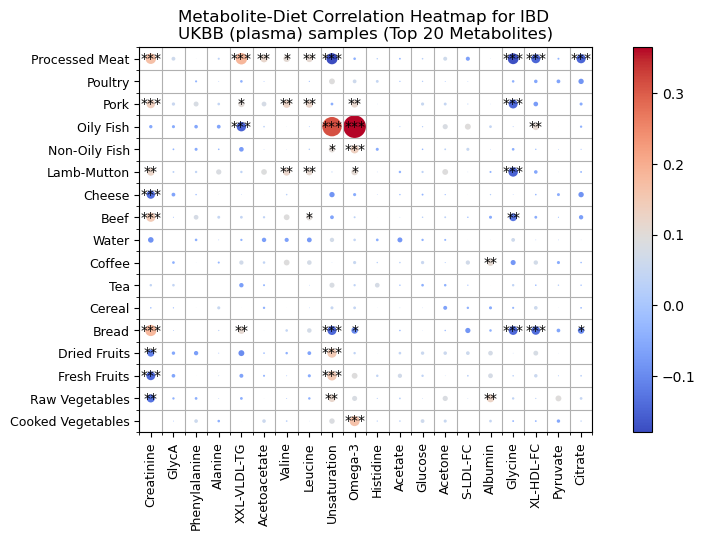

<Figure size 1000x1000 with 0 Axes>

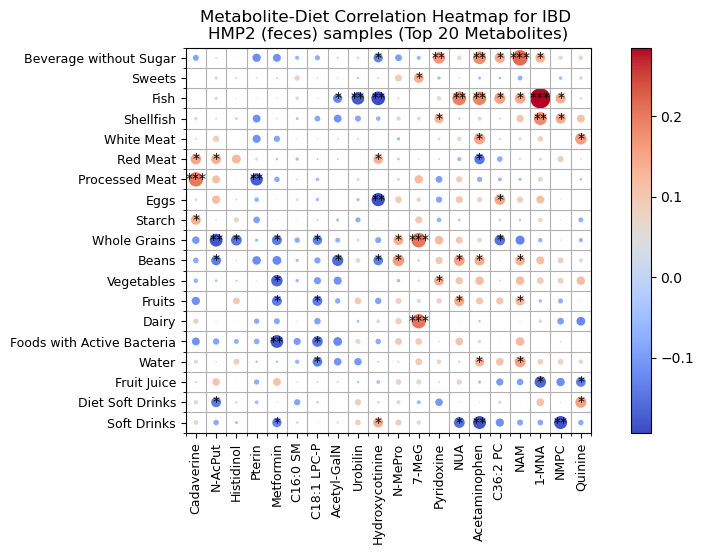

<Figure size 1000x1000 with 0 Axes>

In [17]:
diet_file_path = [
    "../R Processed Data/BBdiet.csv",
    "../R Processed Data/HMPdiet.csv"
]

SHAPmetabolite_file_path = [
    "ML and XAI/X values Shap-Ranked for UKB (plasma).csv",
    "ML and XAI/X values Shap-Ranked for HMP2 (feces).csv"
]

file_names = ["UKBB (plasma)",
         "HMP2 (feces)"]
    
for i in range(len(file_names)):

    x = pd.read_csv(diet_file_path[i], index_col=0)
    y = RankedMetaboliteData[i]
    
    ibd = 1 ## <- EDIT THIS TO GENERATE FIGURES FOR ONLY IBD (1), ONLY NON-IBD (0), OR BOTH (any other number)
    
    if ibd == 0:
        class_id = "Non-IBD"
        y = y[y['Label'] == ibd]
    elif ibd == 1:
        class_id = "IBD"
        y = y[y['Label'] == ibd]
    else:
        class_id = "All"
        
    y = y.loc[:, y.columns != 'Label']
    x = x[x.index.isin(y.index)]
    
    # only display the diet-metabolite heatmap for the top features
    y = y.iloc[:, :len(selected_features_list[0])]

    df = pd.concat([x, y], axis=1)
    
    # calculate correlation
    r = df.rcorr(method='spearman', padjust='fdr_bh').iloc[x.shape[1]:, :-y.shape[1]]
    r.T.to_csv(f"Diet-Metabolite/Correlation Table for {file_names[i]} {class_id}.csv", index=True)
    # calculate significant stars
    stars = df.rcorr(method='spearman', padjust='fdr_bh').iloc[:x.shape[1], x.shape[1]:].T
    # calculate significance
    p = df.rcorr(method='spearman', padjust='fdr_bh', stars=True, decimals = 150).iloc[:x.shape[1], x.shape[1]:].T
    p.T.to_csv(f"Diet-Metabolite/P-value Correlation Table for {file_names[i]} {class_id}.csv", index=True)
    # calculate p-value significance threshold
    p_threshold = 0.05 / (x.shape[1] * y.shape[1])
    
    # calculate extreme correlations (percentile-based)
    values = r.values.astype(float).flatten()
    perc = 5
    lower_percentile = np.percentile(values, perc)
    upper_percentile = np.percentile(values, 100-perc)
    
    # COUNT HOW MANY CORRELATIONS THERE ARE
    print(f"{file_names[i]} {class_id}:")
    print("Total Correlations (|r| >= 0.1):", r.astype(float)[np.abs(r.astype(float)) >= 0.1].count().sum())
    print(f"Total Significant Correlations:", p[(p.applymap(lambda x: x in ["***", "**", "*"])) & (np.abs(r.astype(float)) >= 0.1)].count().sum())
    print(f"lp: {lower_percentile}, up: {upper_percentile}")
    print("Total Extreme Correlations (lp > r > up):", r.astype(float)[(r.astype(float) >= upper_percentile) | (r.astype(float) <= lower_percentile)].count().sum())
#     print("Total Significant Extreme Correlations:", p[(p.applymap(lambda x: x in ["***", "**", "*"])) & ((r.astype(float) >= upper_percentile) | (r.astype(float) <= lower_percentile))].count().sum())
    print()
    
    # --------------------------------------------------------------
    
    # PLOT THE HEATMAP
    
    w, h, f, fr, fc = 13, 5, 13, 9, 9 # width, height, fontsize, fontsize_row, fontsize_col for 
    file_name_map = f"\n {file_names[i]}" # file name for the heatmap

    # Create a plot
    fig, ax = plt.subplots(figsize=(w, h))
    
    # codes below adapted from Ryan Neff: https://gist.github.com/ryananeff/d9824f810d185a2b6e49722de1cc5838 ------
    #----------------------------
    input_colors = r
    row_cluster = True # cluster the metabolites only
    col_cluster = False
    
    # cluster rows or cols by the degree of correlation (input_colors)
    clustergrid = sns.clustermap(input_colors.astype(float),cmap="RdBu_r",
                                row_cluster=row_cluster,col_cluster=col_cluster, method="ward")
    row_order = clustergrid.dendrogram_row.reordered_ind if row_cluster else range(len(input_colors.index))
    col_order = clustergrid.dendrogram_col.reordered_ind if col_cluster else range(len(input_colors.columns))
    
    # re-order the correlation and significance dataframes
    input_colors = input_colors.iloc[row_order,col_order]
    p_ordered = p.iloc[row_order,col_order]
    
    # clears the current figure to prepare for new visualizations
    plt.clf()
    
    N, M = input_colors.shape # N is number of rows (metabolites), M is the number of columns (food groups)
    row_labels = list(input_colors.index)
    col_labels = list(input_colors.columns)

    # x corresponds to food groups, y corresponds to metabolites
    x, y = np.meshgrid(np.arange(M), np.arange(N))
    
    # find the max value to set the maximum circle size for the map
    max_value = input_colors.astype(float).abs().max().max()
    circle_sizes = (input_colors.astype(float).abs() / max_value / 2).values # s
    colors = input_colors.astype(float).values # the colors would vary according to r

    # create the circles and add to the plot; sizes and color vary with data, 
    # patchcollection adds the circles to the map
    R = circle_sizes.flatten() 
    circles = [plt.Circle((j, i), radius=r) for r, i, j in zip(R, x.flat, y.flat)]
    col = PatchCollection(circles, array=colors.flatten(), cmap="coolwarm", norm=mpl.colors.Normalize(vmin=colors.min().min(), vmax=colors.max().max()))
    ax.add_collection(col)
    ax.set_aspect('equal') # Set the aspect ratio to equal for circles to appear properly

    # Customize the ticks and labels
    ax.set(xticks=np.arange(N), yticks=np.arange(M))
    ax.set_xticks(np.arange(N + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(M + 1) - 0.5, minor=True)
    ax.set_xticklabels(row_labels, fontsize=fc, rotation=90)
    ax.set_yticklabels(col_labels, fontsize=fr)
    ax.grid(which='minor')
    # --------------- code adaptation ended
    
    # make the bar aspect ratio proportionate to the map
    im_ratio = input_colors.shape[0]/input_colors.shape[1]
    fig.colorbar(col, fraction=0.046*im_ratio, pad=0.04)
    
    # PLOT THE HEATMAP
    for r, row in enumerate(input_colors.values):
        for s, star in enumerate(row):
            # add stars to the plot if correlation > 0.1
            if abs(float(input_colors.iloc[r,s])) >= 0.1:
                ax.text(r, s, p_ordered.iloc[r, s], va='center', ha='center', color='black', fontsize=10)
#             # indicate extremeness of value
#             if float(input_colors.iloc[r,s]) > upper_percentile or float(input_colors.iloc[r, s]) < lower_percentile:
#                 ax.text(r, s, '+', va='top', ha='center', color='black', fontsize=10)

    ax.set_title(f"Metabolite-Diet Correlation Heatmap for {class_id} \n{file_names[i]} samples (Top 20 Metabolites)", fontsize=12)
    ax.get_figure().savefig(f"Diet-Metabolite/{file_names[i]}_{class_id}_Correlation Heatmap Plot.png",
                dpi=600, bbox_inches='tight')
    
    ax.get_figure().show()